In [2]:
import os

import pandas as pd

import json
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
timing_dir = '../eval/analyze_outputs'
files = [os.path.abspath(os.path.join(timing_dir, f)) for f in os.listdir(timing_dir) if ('.json' in f) and any([(s in f) for s in ['row_icopy', 'row_ipush', 'col_icopy', 'col_copy']])]
files

['/u/antor/u13/ukumaras/Projects/mldb/eval/analyze_outputs/opt_vec_row_icopy_iris5_1000000.json',
 '/u/antor/u13/ukumaras/Projects/mldb/eval/analyze_outputs/opt_vec_col_copy_iris4_5000000.json',
 '/u/antor/u13/ukumaras/Projects/mldb/eval/analyze_outputs/opt_vec_row_ipush_iris4_5000000.json',
 '/u/antor/u13/ukumaras/Projects/mldb/eval/analyze_outputs/opt_vec_row_ipush_iris5_20000000.json',
 '/u/antor/u13/ukumaras/Projects/mldb/eval/analyze_outputs/opt_vec_col_copy_iris3_15000000.json',
 '/u/antor/u13/ukumaras/Projects/mldb/eval/analyze_outputs/opt_vec_col_copy_iris4_20000000.json',
 '/u/antor/u13/ukumaras/Projects/mldb/eval/analyze_outputs/opt_vec_col_icopy_iris5_10000000.json',
 '/u/antor/u13/ukumaras/Projects/mldb/eval/analyze_outputs/opt_vec_row_ipush_iris4_1000000.json',
 '/u/antor/u13/ukumaras/Projects/mldb/eval/analyze_outputs/opt_vec_row_icopy_iris3_15000000.json',
 '/u/antor/u13/ukumaras/Projects/mldb/eval/analyze_outputs/opt_vec_col_icopy_iris3_20000000.json',
 '/u/antor/u13/uk

In [4]:
times_raw = {}

for file in files:
    with open(file, "r") as f:
        name = file.split("/")[-1].split(".")[0]
        workload = name.split("_")[-1]
        key = name.split("_iris")[0]
        run = name.split("_iris")[1][0]
        times_raw[key + "~" + workload + "~" + run] = json.loads(f.read())

In [5]:
times = []

for k, v in times_raw.items():
    t = {}
    t['dataset'] = 'iris'
    t['pipeline'] = k.split("~")[0][8:]
    t['workload'] = k.split("~")[1]
    t['run'] = k.split("~")[2]

    if t['run'] ==  '1':
        prediction = v['children'][0]['children'][0]['children'][0]
    else:
        prediction = v['children'][0]['children'][0]
        # if t['pipeline'] == 'opt_vec2':
        #     print(t['workload'])
        #     pprint(prediction)
    pred_info = prediction['extra_info'].split('|')[1:]
    for i in pred_info:
        kv = i.split(":")
        t[kv[0]] = kv[1]
    
    times.append(t)

In [6]:
times_df = pd.DataFrame.from_records(times).loc[:, ['pipeline', 'workload', 'load', 'move', 'predict', 'move_rev']]
times_df = times_df.melt(id_vars=['pipeline', 'workload'], value_vars=['load', 'move', 'predict', 'move_rev'], var_name='phase', value_name='time')
times_df = times_df.sort_values(['pipeline', 'workload'])
times_df['time'] = times_df['time'].astype(int)

pipeline_map = {
    'col_copy': 'libtorch (best)',
    'col_icopy': 'onnx - col copy',
    'row_icopy': 'onnx - row copy',
    'row_ipush': 'onnx - row append'
}
times_df['pipeline'] = times_df['pipeline'].apply(lambda x: pipeline_map[x])

In [7]:
times_df

,pipeline,workload,phase,time
12,libtorch (best),1000000,load,5517
20,libtorch (best),1000000,load,4932
22,libtorch (best),1000000,load,94547
72,libtorch (best),1000000,move,26331
80,libtorch (best),1000000,move,32948
...,...,...,...,...
144,onnx - row append,5000000,predict,1513244
173,onnx - row append,5000000,predict,1493608
182,onnx - row append,5000000,move_rev,45340
204,onnx - row append,5000000,move_rev,46935


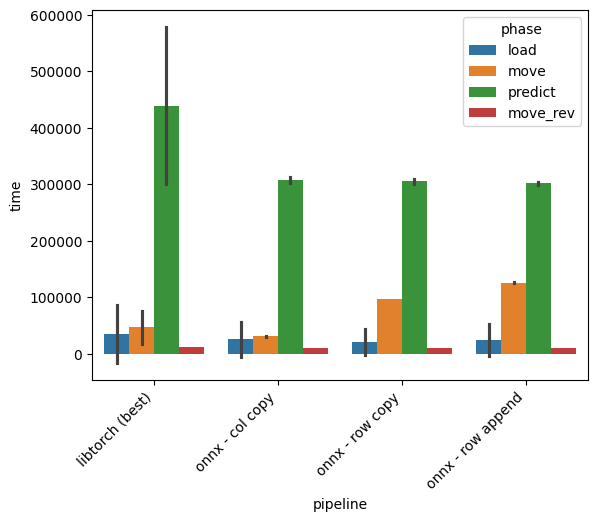

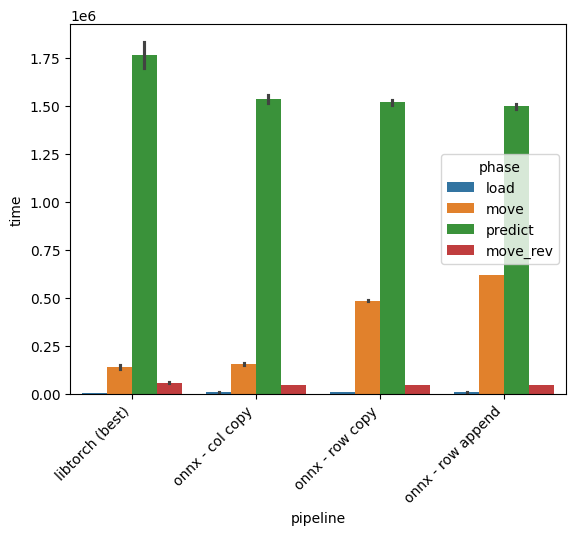

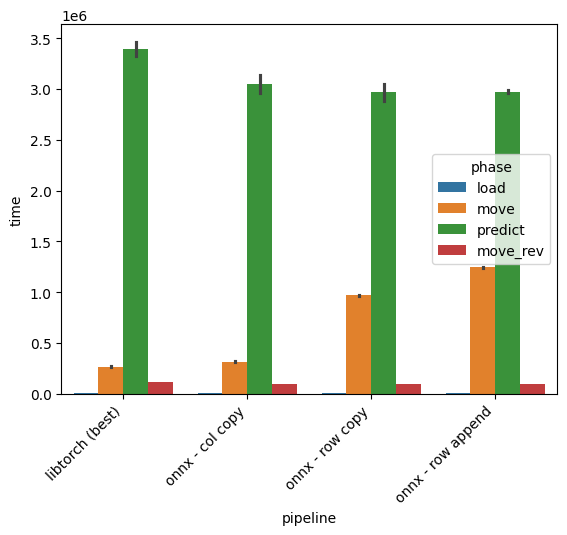

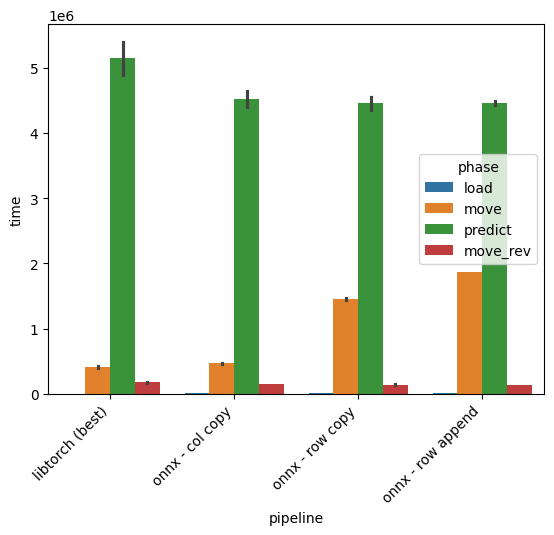

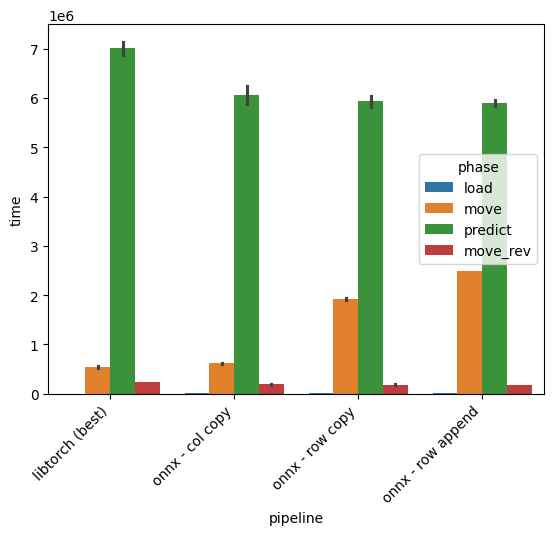

In [8]:
for w in ['1000000', '5000000', '10000000', '15000000', '20000000']:
    sns.barplot(times_df[times_df['workload'] == w], x="pipeline", y="time", hue="phase", errorbar='sd')
    plt.xticks(rotation=45, ha='right')
    plt.show()